In [1]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.

https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

batch_size = 128
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train shape:', X_train.shape)

print(K.image_dim_ordering())


#Verify if the backed of keras is Theano ('th') or TensorFlow ("tf") or Theano ('th'). 
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    print('Using theano')

else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    print('Using tensorflow')
    
    

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


X_train shape: (60000, 28, 28)
th
Using theano
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [2]:
3#linear stack of layers
model = Sequential()

#Add convolutional 2D layer 
# apply a 3x3 convolution with 32 output filters on a 28X28 image:
#border_mode: 'valid' or 'same'. (same' will only work with TensorFlow for the time being.)
'''
border_mode :(str, int or tuple of two int) –
'valid': apply filter wherever it completely overlaps with the
input. Generates output of shape: input shape - filter shape + 1
'''

#Se escogen 32 filtros inicialmente aletorios y sus valores se van modificando con respecto al BP
model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))

#Activation: Applies an activation function to an output.
model.add(Activation('relu')) #rectified linear unit (ReLU): set to zero all negative values and the positive dont change

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
model.add(Activation('relu'))

#Max pooling operation for spatial data.
model.add(MaxPooling2D(pool_size=pool_size))

#Applies Dropout to the input. Dropout consists in randomly setting a fraction p of input units to 0 at each update during training time, which helps prevent overfitting.
# model.add(Dropout(0.25))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())  #eliminate any nested lists by incorporating them as elements----- ???? to make a single colum of data to be the entrance to the fully connected NN?

#Dense: regular fully connected NN layer.
model.add(Dense(128)) # output_dim = 128
model.add(Activation('relu'))

# model.add(Dropout(0.5))
model.add(Dense(nb_classes)) # output_dim = nb_classes = 10

model.add(Activation('softmax')) #softmax -> logistic output function 


model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 26, 26)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 26, 26)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 24, 24)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 32, 24, 24)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [3]:
3from keras import backend as K
import math
import theano
import theano.tensor as T

def quad_kappa(y, t, y_pow=1, eps=1e-15):
    num_scored_items = y.shape[0]
    num_ratings = 10
    tmp = T.tile(T.arange(0, num_ratings).reshape((num_ratings, 1)),
                 reps=(1, num_ratings)).astype(theano.config.floatX)
    weights = (tmp - tmp.T) ** 2 / (num_ratings - 1) ** 2

    y_ = y ** y_pow
    y_norm = y_ / (eps + y_.sum(axis=1).reshape((num_scored_items, 1)))

    hist_rater_a = y_norm.sum(axis=0)
    hist_rater_b = t.sum(axis=0)

    conf_mat = T.dot(y_norm.T, t)

    nom = T.sum(weights * conf_mat)
    denom = T.sum(weights * T.dot(hist_rater_a.reshape((num_ratings, 1)),
                                  hist_rater_b.reshape((1, num_ratings))) /
                  num_scored_items.astype(theano.config.floatX))

    return (1 - nom / denom)


In [4]:
import kappa_methods as kappa
# reload(kappa)
model.compile(loss= 'categorical_crossentropy', #kappa.quad_kappa_loss,
              optimizer='adadelta',
              metrics=['accuracy', quad_kappa]) #The metrics can be custom, depends of the way in wich is desired to measeure the errorr


In [5]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 15s - loss: 0.2707 - acc: 0.9180 - quad_kappa: 0.8596 - val_loss: 0.0805 - val_acc: 0.9772 - val_quad_kappa: 0.9487
Epoch 2/12
60000/60000 [==============================] - 18s - loss: 0.0702 - acc: 0.9790 - quad_kappa: 0.9600 - val_loss: 0.0497 - val_acc: 0.9840 - val_quad_kappa: 0.9671
Epoch 3/12
60000/60000 [==============================] - 20s - loss: 0.0466 - acc: 0.9863 - quad_kappa: 0.9721 - val_loss: 0.0376 - val_acc: 0.9869 - val_quad_kappa: 0.9767
Epoch 4/12
60000/60000 [==============================] - 25s - loss: 0.0351 - acc: 0.9892 - quad_kappa: 0.9792 - val_loss: 0.0382 - val_acc: 0.9870 - val_quad_kappa: 0.9769
Epoch 5/12
60000/60000 [==============================] - 13s - loss: 0.0277 - acc: 0.9916 - quad_kappa: 0.9831 - val_loss: 0.0347 - val_acc: 0.9882 - val_quad_kappa: 0.9793
Epoch 6/12
60000/60000 [==============================] - 11s - loss: 0.0220 - a

In [6]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Test score: 0.0368097717896
Test accuracy: 0.9895


In [7]:
#-------------------------------------------------------------------------

In [8]:
for l in model.layers:
    print(l.trainable)
    l.trainable = False
    
model.compile(loss= 'categorical_crossentropy', #kappa.quad_kappa_loss,
              optimizer='adadelta',
              metrics=['accuracy',  quad_kappa]) #The metrics can be custom, depends of the way in wich is desired to measeure the errorr

True
True
True
True
True
True
True
True
True
True


In [9]:
# model.get_config()

In [10]:
# Real value of kappa training for the last model (Frozen the training) 
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1,
          verbose=1, validation_data=(X_test, Y_test))

# loss: 0.0047 - acc: 0.9988 - quad_kappa: 0.9963 - val_loss: 0.0373 - val_acc: 0.9902 - val_quad_kappa: 0.9856

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 0.0048 - acc: 0.9988 - quad_kappa: 0.9964 - val_loss: 0.0368 - val_acc: 0.9895 - val_quad_kappa: 0.9850


In [12]:
def quadratic_kappa(y, t, eps=1e-15):
    # Assuming y and t are one-hot encoded!
    num_scored_items = y.shape[0]
    num_ratings = y.shape[1] 
    ratings_mat = np.tile(np.arange(0, num_ratings)[:, None], 
                        reps=(1, num_ratings))
#     print("ratings_mat: ", ratings_mat)
#     print("ratings_mat.T: ", ratings_mat.T)

    ratings_squared = (ratings_mat - ratings_mat.T) ** 2
#     print(ratings_squared)    
    weights = ratings_squared / (float(num_ratings) - 1) ** 2
#     print(weights)

    # We norm for consistency with other variations.
    y_norm = y / (eps + y.sum(axis=1)[:, None])
#     print(y)

#     print(y_norm)

    # The histograms of the raters.
    hist_rater_a = y_norm.sum(axis=0)
    hist_rater_b = t.sum(axis=0)
    
#     print(hist_rater_a)
#     print(hist_rater_b)

    # The confusion matrix.
    conf_mat = np.dot(y_norm.T, t)
    
      
#     print("conf_mat: ",conf_mat)


    # The nominator.
    nom = np.sum(weights * conf_mat)
    expected_probs = np.dot(hist_rater_a[:, None], 
                          hist_rater_b[None, :])
    
#     print(nom)
#     print(expected_probs)

    # The denominator.
    denom = np.sum(weights * expected_probs / num_scored_items)
#     print(denom)

    return 1 - nom / denom

In [13]:
pred_classes = model.predict_classes(X_test , batch_size = 1000)  #0.9856

pred_classes_H = np_utils.to_categorical(pred_classes, nb_classes)

k_camila = kappa.kappa(y_test , pred_classes, nb_classes)
k_quad= quadratic_kappa(pred_classes_H , Y_test)

print('\nKappa camila:', k_camila)
print('Kappa quad:', k_quad)

k_camila = kappa.kappa(pred_classes, y_test, nb_classes)
k_quad= quadratic_kappa(Y_test, pred_classes_H)

print('Kappa camila:', k_camila)
print('Kappa quad:', k_quad)


 9000/10000 [==========================>...] - ETA: 0s
Kappa camila: 0.986112235312
Kappa quad: 0.986112232546
Kappa camila: 0.986112232039
Kappa quad: 0.986112232546


In [14]:
pred_classes = model.predict_classes(X_train , batch_size = 1000)  #0.9963
pred_classes_H = np_utils.to_categorical(pred_classes, nb_classes)

k_camila = kappa.kappa(y_train , pred_classes, nb_classes)
k_quad= quadratic_kappa(pred_classes_H , Y_train)

print('\nKappa camila:', k_camila)
print('Kappa quad:', k_quad)

k_camila = kappa.kappa(pred_classes, y_train, nb_classes)
k_quad= quadratic_kappa(Y_train, pred_classes_H)

print('Kappa camila:', k_camila)
print('Kappa quad:', k_quad)

60000/60000 [==============================] - 2s     

Kappa camila: 0.99836422726
Kappa quad: 0.998364227401
Kappa camila: 0.998364227519
Kappa quad: 0.998364227401


In [ ]:
#
acum_k_camila = 0
acum_k_quad = 0

batch = 32

stops = np.arange(0, X_train.shape[0], batch)
stops[0:10]

for i in np.arange(1, len(stops)):
    X_of_batch = X_train[stops[i-1]:stops[i]]
    pred_classes = model.predict_classes(X_of_batch)
    y_of_batch = y_train[stops[i-1]:stops[i]]
    Y_of_batch = Y_train[stops[i-1]:stops[i]]
    pred_classes_H = np_utils.to_categorical(pred_classes, nb_classes)
    
    k_camila = kappa.kappa(pred_classes, y_of_batch, nb_classes)
    k_quad= quadratic_kappa(Y_of_batch, pred_classes_H)
    
#     print('Kappa camila:', k_camila)
#     print('Kappa quad:', k_quad)
    
    acum_k_camila += k_camila
    acum_k_quad += k_quad

    
    
    


print('FINAL Kappa camila:', acum_k_camila/ len(stops))
print('FINAL Kappa quad:', acum_k_quad/ len(stops))


In [22]:
pred_classes = model.predict_classes(X_train , batch_size = 32)  #0.9747
k = kappa.kappa(y_train , pred_classes , nb_classes)

print('\npred_classes:', pred_classes)

print('\ny_train:',y_train)

print('\nKappa:', k)

59776/60000 [============================>.] - ETA: 0s
pred_classes: [5 0 4 ..., 5 6 8]

y_train: [5 0 4 ..., 5 6 8]

Kappa: 0.99836422726


In [ ]:
pred_classes = model.predict_classes(X_train ,batch_size = 32) #0.9747
nb_classes = 10
print('\npred_classes:', pred_classes)

print('\ny_train:',y_train)


pred_classes_H = np_utils.to_categorical(pred_classes, nb_classes)
y_test_Fl = np_utils.to_categorical(y_train, nb_classes)



quadratic_kappa(pred_classes_H , y_test_Fl)

imgArray shape: (50, 50)


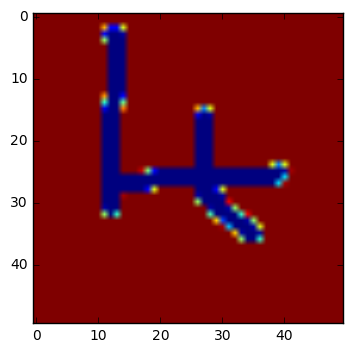

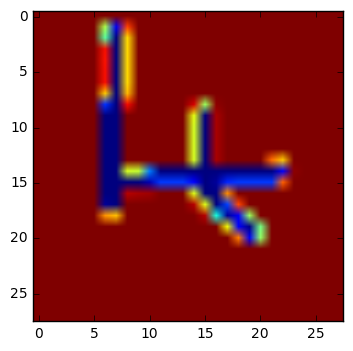

28 28


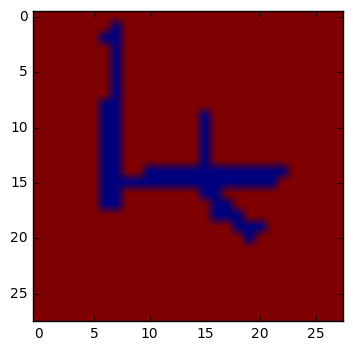

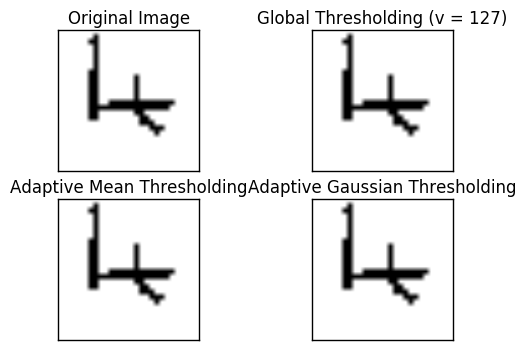

Shape original array:  (28, 28)
Using theano
1/1 [==============================] - 0s

clases: [4]


In [16]:
#Open CV library to binarize the image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import *


#Matplot library for ploting and showing data
import matplotlib.pyplot as plt
#Plote in the same line the graps (instead of in a new windows)
%matplotlib inline

matplotlib.pyplot.close("all")

#Read the image as a numpy array
imgArray = cv2.imread('4.png',0)
print ("imgArray shape:", imgArray.shape)
plt.imshow(imgArray)
plt.show()

#Resize the image
imgArray = cv2.resize(imgArray,(img_rows, img_cols), interpolation = cv2.INTER_LINEAR)
plt.imshow(imgArray)
plt.show()

#Expected output
y_k = np.array([4])

#print ("imgArray shape: %s \n\nArray: %s\n" %(imgArray.shape,imgArray))

row,col =  imgArray.shape



print (row,col)



#imgArray = cv2.medianBlur(imgArray,5)
imgArray[imgArray<128] = 0
imgArray[imgArray>128] = 255
plt.imshow(imgArray)
plt.show()

#Other kinds of binarization-
ret,th1 = cv2.threshold(imgArray,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(imgArray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(imgArray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
cv2.THRESH_BINARY,11,2)
 
titles = ['Original Image', 'Global Thresholding (v = 127)',
             'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [imgArray, th1, th2, th3]
#Plot images
for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
#plt.show()

#Binarization choosen adaptiveThreshold
ImArray = th2;

#RESIZE THE ARRAY TO 28X28
#ImArray = np.resize(ImArray,(img_rows, img_cols))
#ImArray.resize(img_rows, img_cols ,refcheck=False)

plt.imshow(ImArray,cmap='gray')
plt.show()
print("Shape original array: ", ImArray.shape)


ImArray = ImArray.astype('float32')

#Normalization
ImArray /= 255

#Invert image
ImArray = 1 -ImArray

#print(ImArray)



#Reshape iamge

if K.image_dim_ordering() == 'th':
    ImArray = ImArray.reshape(1, 1, img_rows, img_cols)
    print('Using theano')
else:
    ImArray = ImArray.reshape(1,img_rows, img_cols , 1)
    print('Using tensorflow')


#Get correspongig lable to the output
classes = model.predict_classes(ImArray, batch_size=32)

print('\nclases:', classes)


<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=50x50 at 0x7FD60AFC6550>
cover <PIL.Image.Image image mode=RGBA size=28x28 at 0x7FD623EFF910>


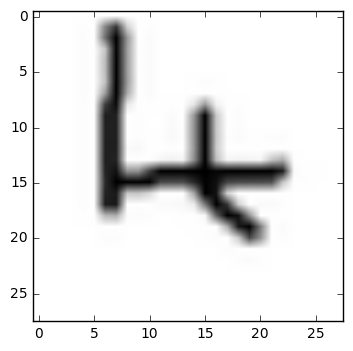

<PIL.Image.Image image mode=L size=28x28 at 0x7FD62BFB1E50>


In [17]:
#---------------------------------------------------------------------------------------------------------------
#Matplot library for ploting and showing data
import matplotlib.pyplot as plt
#Plote in the same line the graps (instead of in a new windows)
%matplotlib inline

#import Pilow image to aloww shoing images
from PIL import Image
img = Image.open('4.png') #('8.jpg')  ('9.png')
print (img)

#Rezise image to get the expected numer of inputs to the network

row,col =  28,28

#from resizeimage import resizeimage #----> DOESN'T WORK IN KLEE
#img = resizeimage.resize_cover(img, [row, col], validate=False)

img = img.resize((row, col), Image.ANTIALIAS)

print("cover", img)


#Expected output
y_k = np.array([4])

#img.show()

plt.imshow(img,cmap='gray')
plt.show()

#row,col =  img.size

#convert to a grayscale image
img = img.convert('L')
print (img)

#Get a list from the opened image
imArray = list(img.getdata())
#Convert list to numpy array
ImArray = np.array(imArray)



In [18]:
print(ImArray.shape)

ImArray = ImArray.astype('float32')

#Normalization
ImArray /= 255

#Invert image
ImArray = 1 -ImArray

#Reshape image to evaluate in the network
    
ImArray = ImArray.reshape(1, 1, row, col)

print(ImArray.shape)


#Get correspongig lable to the output
classes = model.predict_classes(ImArray, batch_size=32)

print('\nclases:', classes)


#Labeling
salida = np_utils.to_categorical(y_k, nb_classes)
#Evaluate model
score1 = model.evaluate(ImArray, salida, verbose=0)

#Get network output
proba = model.predict_proba(ImArray)

#Get correspongig lable to the output
classes = model.predict_classes(ImArray, batch_size=32)

print('\nTest score (loss):', score1[0])  
print('\nTest accuracy (metrics):', score1[1])
print('\n Output:', proba)
print('\nclases:', classes)
       


(784,)
(1, 1, 28, 28)
1/1 [==============================] - 0s

clases: [4]
1/1 [==============================] - 0s

Test score (loss): 0.00781962834299

Test accuracy (metrics): 1.0

 Output: [[  1.59192950e-12   2.10594519e-12   3.06556240e-06   7.18437517e-16
    9.92210865e-01   5.93172430e-13   7.78454402e-03   7.57571605e-09
    1.55220800e-06   2.15492424e-12]]

clases: [4]


In [19]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

 9856/10000 [============================>.] - ETA: 0s

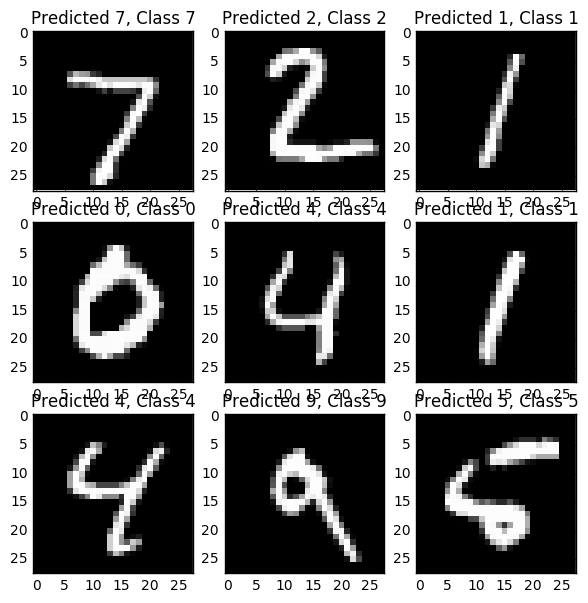

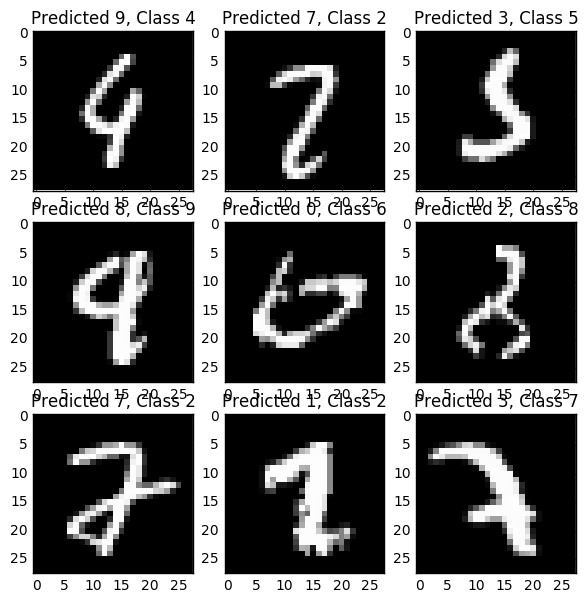

In [20]:
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

In [21]:
import sys
print (sys.version)

2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
